# Node Classification on Facebook Large Page-Page Network

## About dataset

This webgraph is a page-page graph of verified Facebook sites. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies. The task related to this dataset is multi-class node classification for the 4 site categories.

[musae_facebook_target.csv](https://raw.githubusercontent.com/TimKong21/MEMGRAPH-Graph-Analytics-with-NetworkX/main/Asssignments/Assignment%205_Graph%20embeddings%20_machine%20learning/facebook_large/musae_facebook_target.csv)
1. Nodes are the oficial Facebook pages with unique id.
2. Each page is labelled with the page type - 'tvshow', 'government', 'company', 'politician'

[musae_facebook_edges.csv](https://raw.githubusercontent.com/benedekrozemberczki/MUSAE/master/input/edges/facebook_edges.csv) 
1. Edges are the mutual likes between the Facebook pages

## Import necessary modules

In [83]:
import networkx as nx
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import f1_score, jaccard_score, log_loss
from sklearn.metrics import SCORERS

from gensim.models import KeyedVectors, Word2Vec
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

%matplotlib inline

## Data importation and preprocessing

### Edges data 

In [84]:
edges = pd.read_csv('facebook_large/musae_facebook_edges.csv')
print('shape:',edges.shape)
edges.head()

shape: (171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [85]:
edges.shape

(171002, 2)

### Nodes data

In [86]:
nodes = pd.read_csv('facebook_large/musae_facebook_target.csv')
print('shape:',nodes.shape)
nodes.head()

shape: (22470, 4)


,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [87]:
nodes.shape

(22470, 4)

#### Label encoding on page type 
4 main classifications

In [88]:
nodes['page_type'].unique()

array(['tvshow', 'government', 'company', 'politician'], dtype=object)

In [89]:
node_att = preprocessing.LabelEncoder()
node_att.fit(['tvshow', 'government', 'company', 'politician'])
nodes['label_class']=node_att.transform(nodes['page_type'])

In [90]:
nodes['label_class'].unique()

array([3, 1, 0, 2], dtype=int64)

In [91]:
nodes.head()

,id,facebook_id,page_name,page_type,label_class
0,0,145647315578475,The Voice of China 中国好声音,tvshow,3
1,1,191483281412,U.S. Consulate General Mumbai,government,1
2,2,144761358898518,ESET,company,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,government,1
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician,2


## Load graph

In [92]:
def load_graph(nodes, edges): #generate Networkx graph object
    # add edges 
    G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2')
    
    # set node attributes ->label_class
    label_class = pd.Series(nodes.label_class, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=label_class, name='label_class')
    
    # set node attributes ->page type 
    page_type = pd.Series(nodes.page_type, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=page_type, name='page_type')
    
    # set node attributes ->node id
    node_id = pd.Series(nodes.facebook_id, index=nodes.id).to_dict()
    nx.set_node_attributes(G, values=node_id, name='facebook_id')
    
    return G

## Sample graph 

In [93]:
def sample_graph(G, num_samples, seed): #sampling 
    # randomly sample data 
    random.seed(seed) #set random state for next occurance of random elements
    samples = random.sample(list(G.nodes), num_samples)
    
    # remove unsampled nodes
    dump_nodes = []
    for n in tqdm(G):
        if n not in samples:
            dump_nodes.append(n)       
    G.remove_nodes_from(dump_nodes)
    print("Number of sampled nodes(with isolates):", len(list(G.nodes)))
    print("Number of isolates:", len(list(nx.isolates(G))))
    
   
    # remove isolates (nodes with no edges)
    G.remove_nodes_from(list(nx.isolates(G)))
    print("Number of sampled nodes(with isolates removed):", len(list(G.nodes)))
    
    # remove barely connected nodes
    for component in list(nx.connected_components(G)):
        if len(component)<4:
            for node in component:
                G.remove_node(node)
    print("Number of sampled nodes(with small components removed):", len(list(G.nodes)))
    
    return G

## Explore graph

Increase node distance and decrease node size

In [94]:
def vis_graph(G):
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G)
    node_colours = [G.nodes[id]['label_class'] for id in G.nodes]
    nx.draw(G,pos,node_size=10, node_color=node_colours)
    
    return None

## Node2Vec algorithm

The Node2Vec algorithm is a 2-step representation learning algorithm. The two steps are:
1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a **corpus**.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The **Word2Vec** algorithm, is used for calculating the embedding vectors.

In [95]:
# load saved embeddings(.txt) as dict
def load_embeddings(file_path):
    embedding_dict = {}
    first_line = True
    with open(file_path) as f:
        for line in f:
            if first_line:
                first_line = False
                continue
            vector = [float(i) for i in line.strip().split()]
            embedding_dict[int(vector[0])] = vector[1:]
        f.close()
    return embedding_dict

# two steps Node2Vec algorithm
def calculate_embeddings(recalculate_embeddings, G, txt_embeddings_file_path):
    if recalculate_embeddings==True: #calculate emebeddings, or else use existing ones
        # 1. perform random walk to generate corpus 
        rw = BiasedRandomWalk(StellarGraph(G))
        walks = rw.run(
            nodes=list(G.nodes()),  # root nodes
            length=32,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            #seed=42 # make random walk predictable
        )
        print("Number of random walks: {}".format(len(walks)))
        
        # 2. perform Word2Vec to learn embedding vectors and save as .txt
        str_walks = [[str(n) for n in walk] for walk in walks] # str conversion for Word2Vec argument
        model = Word2Vec(str_walks, vector_size=128, window=5, 
                         min_count=0, sg=1, workers=2, epochs=1)
        model.wv.save_word2vec_format(txt_embeddings_file_path) #save to path as .txt
        
    return load_embeddings(txt_embeddings_file_path)

## Node embeddings visualization with TSNE
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [96]:
def vis_node_embeddings(G):
    # Retrieve node embeddings and corresponding subjects(page type)
    model = KeyedVectors.load_word2vec_format('embeddings.txt')  
    node_ids = model.index_to_key #list of node ids(in str)
    node_embeddings = model.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
    node_targets = [G.nodes[int(node_id)]['page_type'] for node_id in node_ids]
    
    # Apply dimension reduction on node embeddings - TSNE
    tsne = TSNE(n_components=2)
    node_embeddings_2d = tsne.fit_transform(node_embeddings)
    
    # visualization
    label_map = {label: idx for idx, label in enumerate(np.unique(node_targets))}
    node_colours = [label_map[target] for target in node_targets]
    plt.figure(figsize=(10,8))
    plt.scatter(node_embeddings_2d[:,0],
                node_embeddings_2d[:,1],
                c=node_colours, alpha=0.9)
    plt.show()
    
    return node_embeddings, node_targets, label_map, node_colours

## Train test split

In [97]:
def split_data(node_embeddings, node_targets):
    # X will hold the 128-dimensional input features
    X = node_embeddings
    # y holds the corresponding target values
    y = np.array(node_targets)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

## Best hyperparameter

In [98]:
def best_kfolds(X_train, y_train):
    solvers = ['lbfgs', 'sag']
    folds = [2, 5, 10, 20]
    n_folds = len(folds)
    accuracies = []

    # Run K-folds
    for k in folds:
        for solver in solvers:
            cv = KFold(k) 
            scores = cross_val_score(LogisticRegression(solver=solver, max_iter=3000), 
                                     X_train, y_train, cv=cv)
            accuracies.append(100 * scores.mean())
            print(f"solver = {solver},"," K = %d ,accuracy = %0.2f%%" % (k, accuracies[-1]))

## Logistic regression classifier  

In [99]:
def train_classifier(X_train, y_train, scoring):
    # use default solver - 'lbfgs'
    clf = LogisticRegressionCV(
        Cs=10, cv=10, scoring=scoring, 
        verbose=2, max_iter=3000,
    )
    clf.fit(X_train, y_train)
    return clf


def test_classifier(X_test, y_test, clf):
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    return y_pred, y_pred_prob
    
    
def classifier_score(clf, X_test, y_test, y_pred, y_pred_prob):
    print(f"Average f1-score: {clf.score(X_test, y_test)}")
    print(f"Average Jaccard score: {jaccard_score(y_test, y_pred, average='weighted')}")
    print(f"Log loss: {log_loss(y_test, y_pred_prob)}")

# Downstream tasks 

## Load graph

Load graph as networkx object

In [100]:
G = load_graph(nodes,edges) #networkx graph object 

## Sample graph
Purpose of sampling is to reduce training time later on 

In [101]:
G = sample_graph(G, 2500, 42) 

100%|█████████████████████████████████████████████████████████████████████████| 22470/22470 [00:01<00:00, 19502.64it/s]


Number of sampled nodes(with isolates): 2500
Number of isolates: 1164
Number of sampled nodes(with isolates removed): 1336
Number of sampled nodes(with small components removed): 1028


## Explore graph 

Visualize the graph to have a general idea of nodes distribution

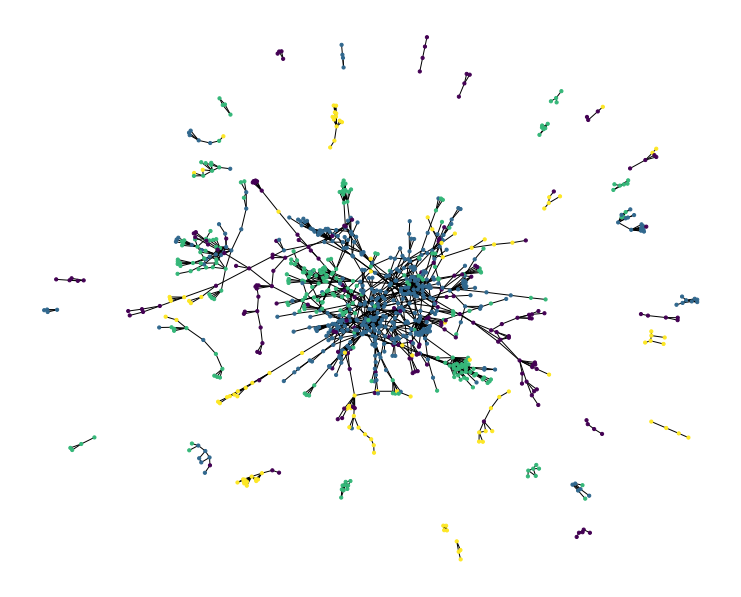

In [102]:
vis_graph(G)

## Calculate embeddings
Choose whether to recalculate embeddings or use the existing

In [103]:
embeddings_dict = calculate_embeddings(True, G, 'embeddings.txt')

Number of random walks: 10280


In [104]:
list(embeddings_dict.items())[:1] #quickly check the 128 vectors of first node

[(18906,
  [-0.017606732,
   0.08580534,
   0.17595693,
   -0.27192605,
   0.116663106,
   -0.15283656,
   0.19219291,
   0.4958948,
   -0.1209884,
   0.88053846,
   -0.24367881,
   -0.3239147,
   -0.3779573,
   0.36460155,
   0.35421795,
   -0.29559833,
   0.073311985,
   0.30300626,
   -0.3946101,
   -0.11663374,
   0.2096309,
   0.69393194,
   0.08534861,
   -0.14331028,
   0.036733665,
   0.69906026,
   -0.34457794,
   0.115889974,
   0.13248272,
   0.08314154,
   -0.07911283,
   -0.10131415,
   -0.3464454,
   -0.1174893,
   -0.4481658,
   0.17092007,
   0.71294224,
   -0.10411533,
   0.5199093,
   0.27079833,
   0.09464013,
   -0.29345706,
   -0.48182592,
   -0.5141505,
   -0.60914195,
   0.18141761,
   -0.45936355,
   0.41367823,
   0.01522251,
   -0.1794581,
   0.10898665,
   0.30971465,
   0.5061597,
   -0.112050265,
   0.57992196,
   -0.10230659,
   0.2937462,
   -0.47985792,
   0.52808076,
   -0.04052218,
   0.12473821,
   -0.031236889,
   -0.106809646,
   0.41526297,
   -0.0

## Visualize node embeddings

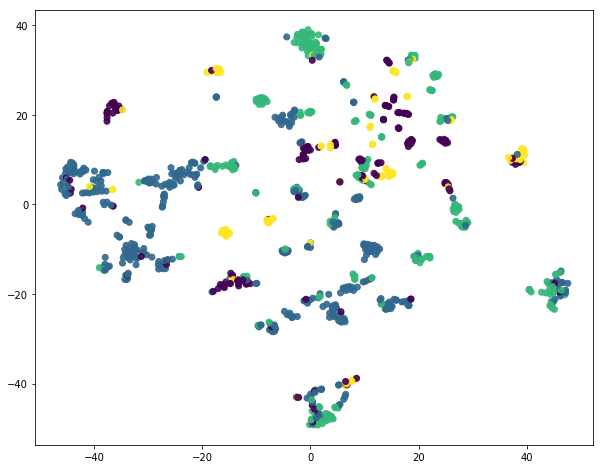

In [105]:
node_embeddings, node_targets, label_map, node_colours = vis_node_embeddings(G)

## Train test split 

In [106]:
X_train, X_test, y_train, y_test = split_data(node_embeddings, node_targets)

## Select best hyperparameter

Solver ``'lbfgs'`` and ``'saga'`` give the same accuracy 

In [107]:
best_kfolds(X_train, y_train) 

solver = lbfgs,  K = 2 ,accuracy = 75.91%
solver = sag,  K = 2 ,accuracy = 75.91%
solver = lbfgs,  K = 5 ,accuracy = 77.49%
solver = sag,  K = 5 ,accuracy = 77.49%
solver = lbfgs,  K = 10 ,accuracy = 78.34%
solver = sag,  K = 10 ,accuracy = 78.34%
solver = lbfgs,  K = 20 ,accuracy = 78.34%
solver = sag,  K = 20 ,accuracy = 78.23%


## Node classification

List out all scoring keys

In [108]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

Let's use default `solver='lbfgs'` and `cv=10` to train our model. Also set ``'f1_weighted'`` as our target scoring metric.

In [109]:
clf = train_classifier(X_train, y_train, 'f1_weighted')
y_pred, y_pred_prob = test_classifier(X_test, y_test, clf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


The accuracy scores are as the followings

In [110]:
classifier_score(clf, X_test, y_test, y_pred, y_pred_prob)

Average f1-score: 0.843467524017642
Average Jaccard score: 0.7310139271239492
Log loss: 0.5068193441795817
